<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/Parallel_CTC_best_result_on_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
n_mels = 80
fs = 44100
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'



with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

# The number of sentences which have wrong labels
error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]


# Wrong label comparison
print(list(metadata[0, 3])) # Correct
print(list(metadata[error_jamos[0], 3])) # Wrong


# Delete wrong data and check the length
print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

# Fix the size of the dataset as a deleted metadata length
dataset_size = len(metadata)

['ᄀ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅫ', 'ᆫ', 'ᄎ', 'ᅡ', 'ᆭ', 'ᄋ', 'ᅳ', 'ᆫ', ' ', 'ᄎ', 'ᅥ', 'ᆨ', 'ᄒ', 'ᅡ', 'ᄅ', 'ᅧ', 'ᄀ', 'ᅩ', ' ', 'ᄋ', 'ᅢ', 'ᄊ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅥ', 'ᆺ', ' ', 'ᄀ', 'ᅡ', 'ᇀ', 'ᄋ', 'ᅡ', 'ᆻ', 'ᄃ', 'ᅡ', '.']
['인', '터', '넷', ' ', '서', '핑', ' ', '중', '이', '에', '요', '.']
(12853, 5)
(12833, 5)


In [0]:
character_length = list() # List of the length of labels
file_length = list() # List of the length of a wav file as sec.
division_length = list() # List of (length of a wav file / length of a label)

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = [] # List of wav file names

for data in metadata:
    wave_name_list.append(data[0])

In [6]:
unicode_jamo_list = list() # List of total hanguel jamos + [' ', ',', '<eos>', 'sos', '!', '?', '-']

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode)) # chr: Change hexadecimal to unicode
    
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    

unicode_jamo_list.sort()

# '-' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['-'] + unicode_jamo_list

# Check the symbols
print(unicode_jamo_list)

# Check the total number of symbols
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
# Create tokenizer, put the whole symbols in and check the output 
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [9]:
# Create mel-spectrogam images from wav files, 
# if mel-spectrogram file already exist, just add their names to the mel_path_list
 
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/mel', npy_name)
    mel_path_list.append(mel_path)
    
    # If you have already saved mel-spectrogram, skip mel creating process
    if not os.path.isfile(mel_path):
        
        y, sr = librosa.core.load(wav_path) # I made a mistake... sr=fs
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
#       Sxx = np.maximum(Sxx, eps)

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

        np.save(mel_path, norm_log_mel_specgram)

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
         
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
                
        
        # (B, T, H)
        
        output_tensor, _ = self.gru(output_tensor)
        
        # (B, T, 2 * H/2)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        
        
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        # Use GPU if GPU is available 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

        self.ctc_loss = nn.CTCLoss().to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Calculate loss
        loss.backward()

        # Update weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        # Must call .train() after loading if you want to train again
        if mode == 'train':
            self.encoder.train()
            self.decoder.train()
        
        # Must call .eval() after loading if you do not want to use dropouts
        elif mode == 'eval':
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(80, 1024, 512)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Threading_Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Threading_Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue()
        self.thread_flags = list()
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])

        self.end_flag = False
        
        self.queue = queue.Queue()
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.mel_path_list, self.ground_truth_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()

        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False

        self.end_flag = True

        return True

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]

                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, mel_path_list, ground_truth_list, load_idxs_list, queue, batch_size, thread_flags, id):
        
        threading.Thread.__init__(self)
        self.mel_path_list = mel_path_list
        self.ground_truth_list = ground_truth_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            self.queue.put(batch)

        self.thread_flags[self.id] = True

        return 

    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
            
            mel_path = self.mel_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.load_mel(mel_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
        
            # pad_random = np.random.randint(0, 5)
            
            # # Time shift, add zeros in front of an image
            # if pad_random > 0:
            #     offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
            #     target = torch.cat((offset, target), 1)
            
            # # Add random noise
            # target = target + (torch.rand(target.shape) - 0.5) / 20
        
            # # Value less than 0 or more than 1 is clamped to 0 and 1
            # target = torch.clamp(target, min=0.0, max=1.0)
            
            # batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target

            batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list]

    def load_mel(self, mel_path):
        norm_log_mel_specgram = np.load(mel_path)
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input


In [0]:
# Create true sentence list, <eos> is added to the end
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [14]:
print(len(mel_path_list))

print(len(ground_truth_list))

# 80% of the data will be used as train
split_index = int(0.8 * len(mel_path_list))

# Split index is the number stands for 80%
print(split_index)

# Split index is the number stands for 80%
mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_eval = mel_path_list[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]

print(len(mel_path_list_eval))

12833
12833
10266
10266
2567


In [0]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_eval = Threading_Batched_Preloader(mel_path_list_eval, ground_truth_list_eval, 64)

preloader_train = Threading_Batched_Preloader(mel_path_list_train, ground_truth_list_train, 64)

In [0]:
# preloader_train.initialize_batch(16)

# counter = 0
# while preloader_train.end_flag == False:

#     batch = preloader_train.get_batch()
#     if batch != None:
#         tensor_input, ground_truth, loss_mask, length_list = batch

#         print(tensor_input.shape)

#     counter += 1

#     print(counter)

In [0]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

09-13 08:37:40
Mean Train Loss: 0.026432421808313972
Mean Evaluation Loss: 0.04658097274630139
-------------------------------------------------------------------------------------------------------
09-13 08:44:57
Mean Train Loss: 0.03673294405668318
Mean Evaluation Loss: 0.029737437353206747
-------------------------------------------------------------------------------------------------------
09-13 08:45:21
Mean Train Loss: 0.02645867421802493
Mean Evaluation Loss: 0.02820476547517487
-------------------------------------------------------------------------------------------------------
09-13 08:45:47
Mean Train Loss: 0.023656631035779703
Mean Evaluation Loss: 0.02666580501142028
-------------------------------------------------------------------------------------------------------
09-13 08:46:12
Mean Train Loss: 0.022568041661885314
Mean Evaluation Loss: 0.025663423317821003
-------------------------------------------------------------------------------------------------------
09-13

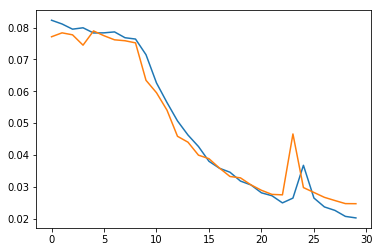

어---------------------리언 문제 늠 배---고ᅩ----  다-른것으ᅳᆯ 언저 헐어-ᄅ-----------------------------------------------------라.<eos><eos>
어리언 문제 늠 배고 다른것을 언저 헐어ᄅ라.<eos>
어려운 문제는 빼고 다른 것들 먼저 풀어라.<eos>----------


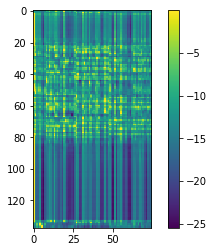

테------------------그ᄅ라 곡푸ᄌᄌᆼᆼ말자ᄋ에서  한ᄌ자  아-때--------------------------------요?<eos><eos>
테그라 곡푸ᄌᆼ말자에서 한자 아때요?<eos>
퇴근하고 포장마차에서 한잔 어때요?<eos>---------


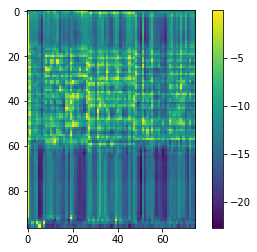

-------------------------------------------------------------------------------------------------------
09-13 08:47:27
Mean Train Loss: 0.01989415556680961
Mean Evaluation Loss: 0.023639712891411018
-------------------------------------------------------------------------------------------------------
09-13 08:47:52
Mean Train Loss: 0.019197315676596743
Mean Evaluation Loss: 0.02308009673530857
-------------------------------------------------------------------------------------------------------
09-13 08:48:16
Mean Train Loss: 0.017771379009040196
Mean Evaluation Loss: 0.02340420920039985
-------------------------------------------------------------------------------------------------------
09-13 08:48:41
Mean Train Loss: 0.01725242102789628
Mean Evaluation Loss: 0.0228604198906164
-------------------------------------------------------------------------------------------------------
09-13 08:49:06
Mean Train Loss: 0.016862762383729732
Mean Evaluation Loss: 0.0219555322215031
--------

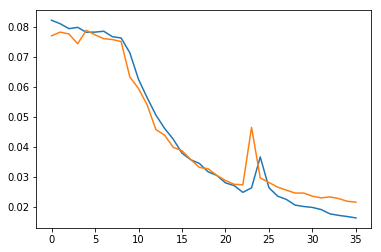

저-------------는 학생 ᅳᅳᆯ록부ᄐᄐ터  그ᅳ련 잘-몬을ᆯ  고ᅩᆮ작ᆯ 가-아ᅡ----------------------------------------------------------요.<eos><eos>
저는 학생 ᅳᆯ록부터 그련 잘몬을 곧작ᆯ 가아요.<eos>
저는 학생들로부터 그런 질문을 곧잘 받아요.<eos>------


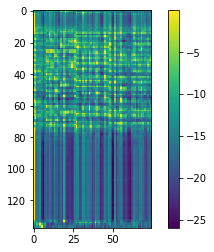

시---------------------ᆫ청 다-들를ᄀ게-  시-ᄋᆨᆷ 바ᄋ에그ᅢ  수개ᄋ해 주시ᄀ겠ᆻ어ᅥ----------------------------요?<eos><eos>
신청 다들를게 시ᄋᆨᆷ 바에그ᅢ 수개ᄋ해 주시겠어요?<eos>
시청자들에게 새 음반에 대해 소개해 주시겠어요?<eos>-------


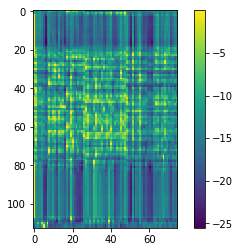

-------------------------------------------------------------------------------------------------------
09-13 08:49:56
Mean Train Loss: 0.016120464122855605
Mean Evaluation Loss: 0.023374316558871885
-------------------------------------------------------------------------------------------------------
09-13 08:50:21
Mean Train Loss: 0.01542757866297289
Mean Evaluation Loss: 0.023035061709407445
-------------------------------------------------------------------------------------------------------
09-13 08:50:45
Mean Train Loss: 0.015517616231667149
Mean Evaluation Loss: 0.022226395072643998
-------------------------------------------------------------------------------------------------------
09-13 08:51:10
Mean Train Loss: 0.014602997070344912
Mean Evaluation Loss: 0.021896563610094587
-------------------------------------------------------------------------------------------------------
09-13 08:51:35
Mean Train Loss: 0.014562957480962029
Mean Evaluation Loss: 0.021686425070909728
-

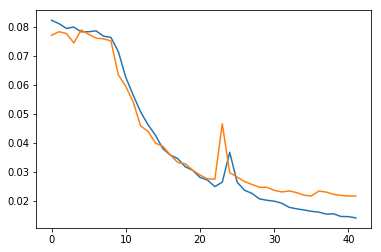

내--------------이 간 교-에-서ᅥ--  ᄌ제지-돌로  초하ᅡᄒ히양한 가---------------------------------------요.<eos><eos>
내이 간 교에서 제지돌로 초하히양한 가요.<eos>
내일 학교에서 제주도로 수학여행을 가요.<eos>---


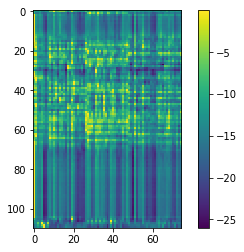

어------------주ᅮ 선 세일이  가장ᄋ이  뜬 것으ᅳᆫ--  최-증ᆼ 조-저-이-------------------------------------다.<eos><eos>
어주 선 세일이 가장이 뜬 것은 최증 조저이다.<eos>
권투 선수에게 가장 힘든 것은 체중 조절이다.<eos>-------


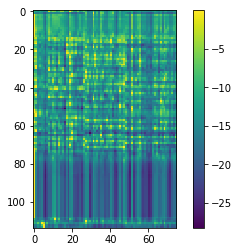

-------------------------------------------------------------------------------------------------------
09-13 08:52:26
Mean Train Loss: 0.013445341446244171
Mean Evaluation Loss: 0.02153618957974847
-------------------------------------------------------------------------------------------------------
09-13 08:52:52
Mean Train Loss: 0.012698856065685216
Mean Evaluation Loss: 0.021756281903735585
-------------------------------------------------------------------------------------------------------
09-13 08:53:16
Mean Train Loss: 0.012847461908291603
Mean Evaluation Loss: 0.02184843136162594
-------------------------------------------------------------------------------------------------------
09-13 08:53:41
Mean Train Loss: 0.012183925125072865
Mean Evaluation Loss: 0.020947241462096863
-------------------------------------------------------------------------------------------------------
09-13 08:54:05
Mean Train Loss: 0.012073696638026805
Mean Evaluation Loss: 0.021342068334175242
--

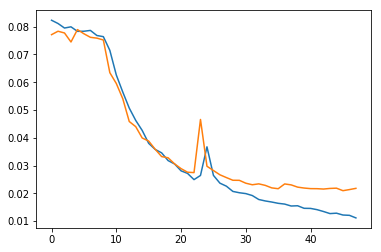

바----------------------뿐 일에 있에ᄉ서--- 감만 일어ᄂ나ᄀ겠ᄉᄉ스--ᆸᆸᄂ니ᅵᅵ-------------------------------------다.<eos><eos>
바뿐 일에 있에서 감만 일어나겠습니다.<eos>
바쁜 일이 있어서 그만 일어나겠습니다.<eos>---


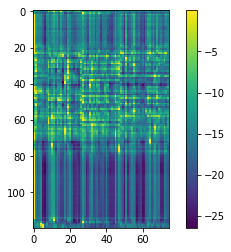

저-----------------는ᆫ 연자하ᅡᄌ질ᅡ는 아ᄁ기가 한나ᄃ다  없ᄋ어-------------------------------------------------요.<eos><eos>
저는 연자하질ᅡ는 아ᄁ기가 한나다 없어요.<eos>
저는 연주할 줄 아는 악기가 하나도 없어요.<eos>-----------


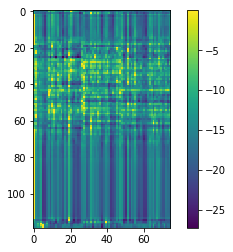

-------------------------------------------------------------------------------------------------------
09-13 08:54:57
Mean Train Loss: 0.01105808061449331
Mean Evaluation Loss: 0.0212661275560238
-------------------------------------------------------------------------------------------------------
09-13 08:55:21
Mean Train Loss: 0.010736193746580148
Mean Evaluation Loss: 0.02117720060679442
-------------------------------------------------------------------------------------------------------
09-13 08:55:46
Mean Train Loss: 0.011367056179751018
Mean Evaluation Loss: 0.02224495931005073
-------------------------------------------------------------------------------------------------------
09-13 08:56:11
Mean Train Loss: 0.01060449950307871
Mean Evaluation Loss: 0.020980669623934266
-------------------------------------------------------------------------------------------------------
09-13 08:56:35
Mean Train Loss: 0.010321644702173205
Mean Evaluation Loss: 0.020541893307564188
------

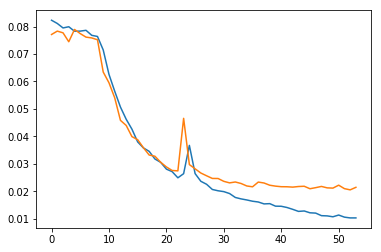

제----------ᄀ가 해ᅢ 볼ᆯ게------------------------------------------요.<eos><eos>
제가 해 볼게요.<eos>
제가 해 볼게요.<eos>-------


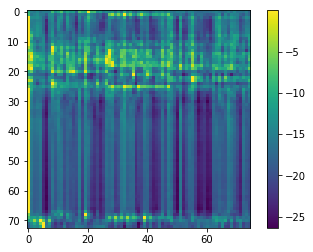

부-----------------대 칙 고-낭이-ᄀ가------  저- 납우ᄋ이 엏똫켈ᄋᆯᆫ나ᄀ같-ᄌ지---------------------------------?<eos><eos>
부대 칙 고낭이가 저 납우이 엏똫켈ᄋᆯᆫ나같지?<eos>
도대체 고양이가 저 나무 위로 어떻게 올라갔지?<eos>----------


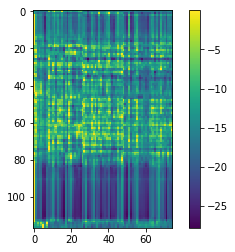

-------------------------------------------------------------------------------------------------------
09-13 08:57:27
Mean Train Loss: 0.010205339303658639
Mean Evaluation Loss: 0.021800702820586083
-------------------------------------------------------------------------------------------------------
09-13 08:57:52
Mean Train Loss: 0.009334628998569303
Mean Evaluation Loss: 0.02152334740444252
-------------------------------------------------------------------------------------------------------
09-13 08:58:16
Mean Train Loss: 0.009359839826023777
Mean Evaluation Loss: 0.02125249025376241
-------------------------------------------------------------------------------------------------------
09-13 08:58:41
Mean Train Loss: 0.009534040472957415
Mean Evaluation Loss: 0.02171494574440522
-------------------------------------------------------------------------------------------------------
09-13 08:59:05
Mean Train Loss: 0.00916775603663758
Mean Evaluation Loss: 0.02156417468876996
-----

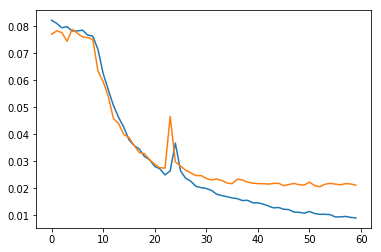

그------------- 거 노ᄄ엏게 알았니ᅵ-----------------------------?<eos><eos>
그 거 노ᄄ엏게 알았니?<eos>
그걸 어떻게 알았니?<eos>


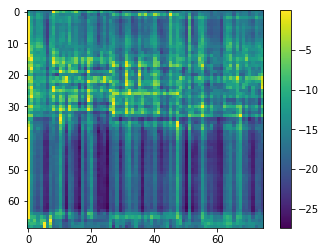

모------------------든 슨개-ᄃ들은ᆫ--  자-석 ᅳᄅᆯᆯ틀를 매애ᅣ 하-----ᆸᆸ니ᅵ-------------다.<eos><eos>
모든 슨개들은 자석 ᅳᄅᆯ틀를 매애ᅣ 합니다.<eos>
모든 승객들은 좌석 벨트를 매야 합니다.<eos>


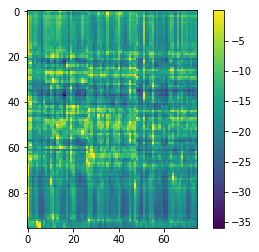

-------------------------------------------------------------------------------------------------------
09-13 08:59:55
Mean Train Loss: 0.008272410163171326
Mean Evaluation Loss: 0.020482253820739846
-------------------------------------------------------------------------------------------------------
09-13 09:00:20
Mean Train Loss: 0.00819290669677764
Mean Evaluation Loss: 0.021592814048804268
-------------------------------------------------------------------------------------------------------
09-13 09:00:45
Mean Train Loss: 0.007422949032699524
Mean Evaluation Loss: 0.020178907392914537
-------------------------------------------------------------------------------------------------------
09-13 09:01:10
Mean Train Loss: 0.007564195967001137
Mean Evaluation Loss: 0.021278179363308253
-------------------------------------------------------------------------------------------------------
09-13 09:01:35
Mean Train Loss: 0.007622176418528185
Mean Evaluation Loss: 0.021764362388017707
-

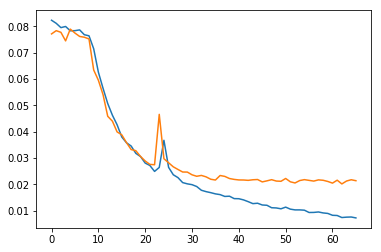

이---------- 백 자-  원-고--지------------------------------------------------.<eos><eos>
이 백 자 원고지.<eos>
이백 자 원고지<eos>-------


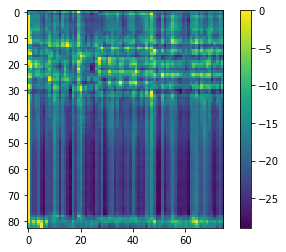

지----------------금 게ᅫ-차ᅡ느ᅳᆫ 데------  이-치가  마ᄋᆷᆷᄋ ᄋ안 들어-------------------------요.<eos><eos>
지금 게ᅫ차는 데 이치가 마ᄋᆷᄋ 안 들어요.<eos>
집은 괜찮은데 위치가 마음에 안 들어요.<eos>-


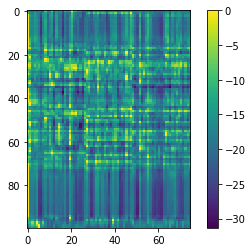

-------------------------------------------------------------------------------------------------------
09-13 09:02:26
Mean Train Loss: 0.0074946520641877325
Mean Evaluation Loss: 0.021277337955086607
-------------------------------------------------------------------------------------------------------
09-13 09:02:51
Mean Train Loss: 0.00759273625335002
Mean Evaluation Loss: 0.02047330850195606
-------------------------------------------------------------------------------------------------------
09-13 09:03:17
Mean Train Loss: 0.006722643281954965
Mean Evaluation Loss: 0.021629113033128426
-------------------------------------------------------------------------------------------------------
09-13 09:03:42
Mean Train Loss: 0.006468228770605383
Mean Evaluation Loss: 0.021571419206406487
-------------------------------------------------------------------------------------------------------
09-13 09:04:07
Mean Train Loss: 0.006482126919791541
Mean Evaluation Loss: 0.020524402012386075
-

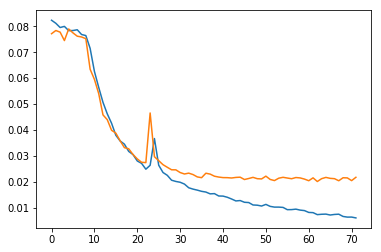

제-----------------숨에-ᄉ서-그ᄂ는ᆫ-- ᄆ무슥 판ᄀ굘ᅳᆯ 바ᅡᆽ고ᅩ  서ᅥᆨ방-되-어-----ᆻᆻ----------------------------------다.<eos><eos>
제숨에서그는 무슥 판굘ᅳᆯ 밪고 석방되었다.<eos>
재심에서 그는 무죄 판결을 받고 석방되었다.<eos>-------


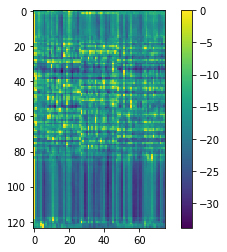

죄------------------숭하ᄌ지ᄆ만  짐이 묵게 지아ᅡ을 남었ᆻᄉ스ᅳ--ᆸᆸᄂ니ᅵ-------------------------------다..<eos>
죄숭하지만 짐이 묵게 지아을 남었습니다.<eos>
죄송하지만, 짐이 무게 제한을 넘었습니다.<eos>-----------


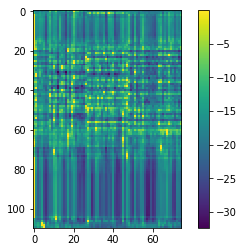

-------------------------------------------------------------------------------------------------------
09-13 09:04:57
Mean Train Loss: 0.0067366735725851315
Mean Evaluation Loss: 0.021593647308681792
-------------------------------------------------------------------------------------------------------
09-13 09:05:23
Mean Train Loss: 0.006241188993679969
Mean Evaluation Loss: 0.021421449721349163
-------------------------------------------------------------------------------------------------------
09-13 09:05:48
Mean Train Loss: 0.005596263752704405
Mean Evaluation Loss: 0.02257838170356068
-------------------------------------------------------------------------------------------------------
09-13 09:06:12
Mean Train Loss: 0.005529761565847326
Mean Evaluation Loss: 0.022050468133480685
-------------------------------------------------------------------------------------------------------
09-13 09:06:37
Mean Train Loss: 0.005483426549000007
Mean Evaluation Loss: 0.023071379264130148


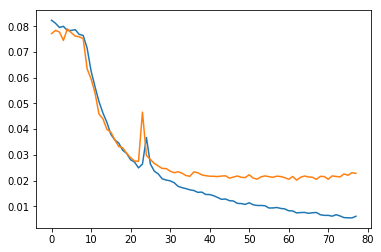

도-------------------ᆼ절을 죽으려ᅧ고 ᄒ훠리를 굽히-다-----  바-지ᄀ가 짖어 져 버려ᅧᆻᄋ어---------------------------------------------------------요.<eos><eos>
동절을 죽으려고 훠리를 굽히다 바지가 짖어 져 버렸어요.<eos>
동전을 주우려고 허리를 굽히다 바지가 찢어져 버렸어요.<eos>-----------


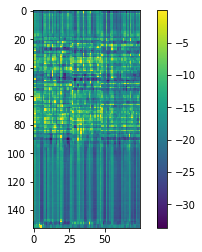

아-----------------머-지는ᆫ 예슨이  넣우셔ᅧᆻᆻ어ᅥ-----------------------------요.<eos><eos>
아머지는 예슨이 넣우셨어요.<eos>
아버지는 예순이 넘으셨어요.<eos>----


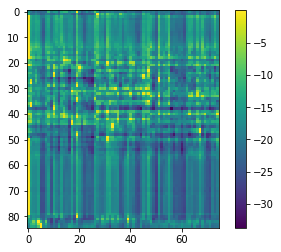

-------------------------------------------------------------------------------------------------------
09-13 09:07:28
Mean Train Loss: 0.00623239575740991
Mean Evaluation Loss: 0.0217281352291774
-------------------------------------------------------------------------------------------------------
09-13 09:07:53
Mean Train Loss: 0.006095335869558458
Mean Evaluation Loss: 0.021930080504273152
-------------------------------------------------------------------------------------------------------
09-13 09:08:18
Mean Train Loss: 0.005572310878830974
Mean Evaluation Loss: 0.023907931461864807
-------------------------------------------------------------------------------------------------------
09-13 09:08:43
Mean Train Loss: 0.006133034824321567
Mean Evaluation Loss: 0.02205592577052807
-------------------------------------------------------------------------------------------------------
09-13 09:09:08
Mean Train Loss: 0.005773251740738018
Mean Evaluation Loss: 0.0221222236629503
------

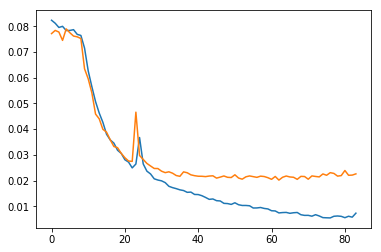

아--------------------드ᅳᆯ이 동ᄆᆯᆯᅥᆫ에 가-자ᄀ고-  졸ᆯ라-------ᆻᆻ-----------------------------------------다.<eos><eos>
아들이 동ᄆᆯᅥᆫ에 가자고 졸랐다.<eos>
아들이 동물원에 가자고 졸랐다.<eos>-----------


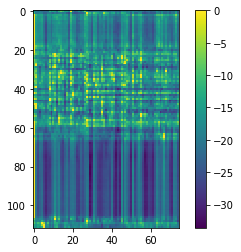

저-----------------------느--  사ᄒ이로ᅩ 사-가 주ᄉ십시ᅵ----------------------오.<eos><eos>
저느 사ᄒ이로 사가 주십시오.<eos>
저를 사위로 삼아 주십시오.<eos>------


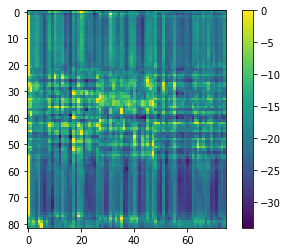

-------------------------------------------------------------------------------------------------------
09-13 09:09:58
Mean Train Loss: 0.006207650415632598
Mean Evaluation Loss: 0.022751728547614123
-------------------------------------------------------------------------------------------------------
09-13 09:10:23
Mean Train Loss: 0.006172860175584609
Mean Evaluation Loss: 0.022103010485469858
-------------------------------------------------------------------------------------------------------
09-13 09:10:48
Mean Train Loss: 0.005631126250674597
Mean Evaluation Loss: 0.022125772085174106
-------------------------------------------------------------------------------------------------------
09-13 09:11:12
Mean Train Loss: 0.005169437032926715
Mean Evaluation Loss: 0.02254893168507816
-------------------------------------------------------------------------------------------------------
09-13 09:11:37
Mean Train Loss: 0.005223508837950028
Mean Evaluation Loss: 0.021428755397904557
-

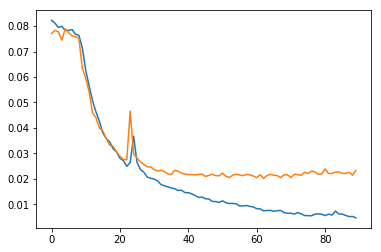

저-------------는 여ᅧ헙 사ᄋ워으ᄅ러ᄉ서--  십 년ᄋᆯ 경엄을 갖고 있ᆻᄉ스--ᆸᆸᄂ니ᅵᅵ------------------------------------------------------다..<eos>
저는 여헙 사워으러서 십 년ᄋᆯ 경엄을 갖고 있습니다.<eos>
저는 영업 사원으로서 십 년의 경험을 갖고 있습니다.<eos>---------


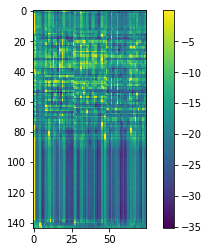

저--------------희 가기에- 손님ᄋ은  주ᄅ로 의-국긴니ᅵᄋ에-------------------------------요.<eos><eos>
저희 가기에 손님은 주로 의국긴니에요.<eos>
저희 가게의 손님은 주로 외국인이에요.<eos>-----


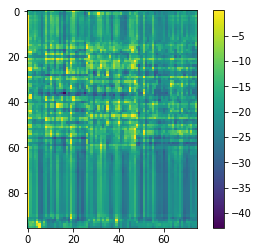

-------------------------------------------------------------------------------------------------------
09-13 09:12:29
Mean Train Loss: 0.009470796382969587
Mean Evaluation Loss: 0.024658050597257914
-------------------------------------------------------------------------------------------------------
09-13 09:12:53
Mean Train Loss: 0.007857545898784565
Mean Evaluation Loss: 0.024133251225337
-------------------------------------------------------------------------------------------------------
09-13 09:13:19
Mean Train Loss: 0.00652151277016445
Mean Evaluation Loss: 0.023158755986388533
-------------------------------------------------------------------------------------------------------
09-13 09:13:43
Mean Train Loss: 0.005623981088561843
Mean Evaluation Loss: 0.022312097287073913
-------------------------------------------------------------------------------------------------------
09-13 09:14:09
Mean Train Loss: 0.005301151498982608
Mean Evaluation Loss: 0.024023991808413515
----

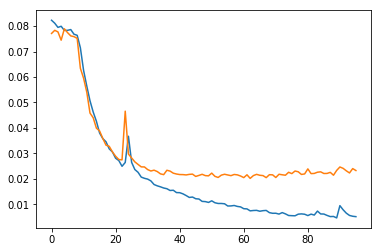

아-------------ᆷ으ᅳᆫᆫ ᄌ종기 발ᄀ견이 ᄋ아주ᅮ 중요-하ᅡ-------------------------------------------------------다.<eos><eos>
암은 종기 발견이 아주 중요하다.<eos>
암은 조기 발견이 아주 중요하다.<eos>-----------


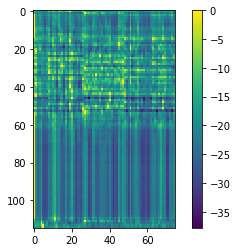

이---------------- 지-도-와ᄋ  성훠-ᆯ도  면-두-도- 하ᅡᄌ지  못해ᅢᆻ어---------------------요.<eos><eos>
이 지도와ᄋ 성훨도 면두도 하지 못했어요.<eos>
이 주 동안 샤워도, 면도도 하지 못했어요.<eos>--


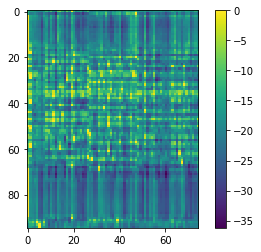

-------------------------------------------------------------------------------------------------------
09-13 09:14:59
Mean Train Loss: 0.004580875279369991
Mean Evaluation Loss: 0.02339853603449967
-------------------------------------------------------------------------------------------------------
09-13 09:15:24
Mean Train Loss: 0.004646563001455233
Mean Evaluation Loss: 0.022548653707024646
-------------------------------------------------------------------------------------------------------
09-13 09:15:48
Mean Train Loss: 0.004401053662782661
Mean Evaluation Loss: 0.02235787126501506
-------------------------------------------------------------------------------------------------------
09-13 09:16:13
Mean Train Loss: 0.004190647695908584
Mean Evaluation Loss: 0.02289916606234225
-------------------------------------------------------------------------------------------------------
09-13 09:16:38
Mean Train Loss: 0.0050145781042678994
Mean Evaluation Loss: 0.023956729647825487
--

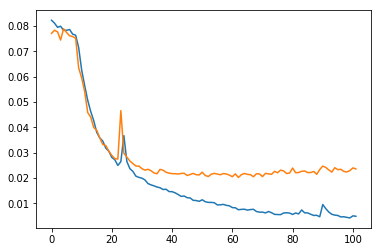

이-------------ᆯ다ᅡᆫ 밖부ᄐ터 먹-ᄌ------------------------------------ᅡ.<eos><eos>
일단 밖부터 먹자.<eos>
일단 밥부터 먹자.<eos>--


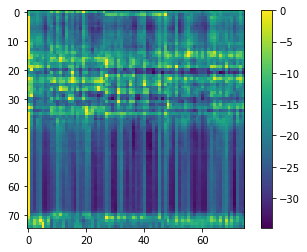

시------------------ᆷ푸ᄀ가  정말 미인이ᅵ네ᅦ--------------------------------------------요.<eos><eos>
심푸가 정말 미인이네요.<eos>
신부가 정말 미인이네요!<eos>-------------------


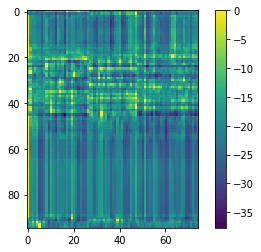

-------------------------------------------------------------------------------------------------------
09-13 09:17:29
Mean Train Loss: 0.004210675021481323
Mean Evaluation Loss: 0.02427365336131416
-------------------------------------------------------------------------------------------------------
09-13 09:17:54


In [0]:
EPOCH = 2 * 60 * 1

# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'parallel_test'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")
    
# Load model if model weights already exists
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch(16)
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list = batch
            pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_eval.initialize_batch(16)
    loss_list_eval = list()
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth_, loss_mask, length_list = batch
            pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))

    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        # index is the position of the max probility of the first batch
        # Shape of the pred_tensor: (T, B, 75)
        # Shape of the index: (T)
        _, index = pred_tensor[:, 0, :].max(-1)

        # Change index numbers to character
        sentence = tokenizer.num2word(index.view(-1))
        
        # Change list to string
        print(''.join(sentence))
        
        # Remove "blank" and overlapping characters
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        # Plot image
        # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)